<a href="https://colab.research.google.com/github/Narasimhag/Stout_Case_Study/blob/main/Stout_Narasimha_Case_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Downloading data

The following code imports the data set from the given Kaggle URL, https://www.kaggle.com/ntnu-testimon/paysim1. Using these instructions, https://medium.com/@opalkabert/downloading-kaggle-datasets-into-google-colab-fb9654c94235

In [4]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [7]:
!cp kaggle.json ~/.kaggle/

from google.colab import files

files.upload()

In [8]:
!kaggle datasets download -d ntnu-testimon/paysim1
!ls

 98% 174M/178M [00:01<00:00, 109MB/s]
100% 178M/178M [00:01<00:00, 108MB/s]
kaggle.json  paysim1.zip  sample_data


In [9]:
!chmod 600 /root/.kaggle/kaggle.json

In [10]:
!unzip paysim1.zip

Archive:  paysim1.zip
  inflating: PS_20174392719_1491204439457_log.csv  


In [11]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')

## Description and issues

Including the data description, as it is useful to reference while finding some issues below.

#### Headers
This is a sample of 1 row with headers explanation:

1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount -
amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [12]:
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


> It is understood that the dataset is a simulation of the emerging mobile money transactions and the columns give us picture of when the transaction happened, what is its type, what amount is transferred, from and to accounts, their respective balances prior to the transaction and after it, if fraud occured and if it flagged as a fraud.

In [13]:
df.isnull().values.any()

False

There are no null values in the dataset, but that doesn't eliminate the factor that nulls might have been filled with 0 as a filler value.

In [14]:
set(df.loc[df['isFraud'] == 1].type.values)

{'CASH_OUT', 'TRANSFER'}

We can also observe that the fraud happens only when the transaction type is either 'CASH_OUT' ot 'TRANSFER'.

In [15]:
df[df['isFlaggedFraud'] == 1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


We can observe from the results above, that 'isFraud' is always '1' when 'isFraudFlagged' is 1. And the transaction type is only 'TRANSFER'.

In [16]:
len(df[df['isFlaggedFraud'] == 1].values)

16

Only 16 values having their 'isFraudFlagged' set to 1 seems like an issue given that the description of dataset says it is set when a transfer of 200000 or greater is made. The following code shows that it is not true. 

In [17]:
df.loc[(df['isFlaggedFraud'] == 0) & (df['amount'] > 200000)]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.00,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0
82,1,TRANSFER,224606.64,C873175411,0.00,0.0,C766572210,354678.92,0.00,0,0
84,1,TRANSFER,379856.23,C1449772539,0.00,0.0,C1590550415,900180.00,19169204.93,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0


In [18]:
df.loc[(df['isFlaggedFraud'] == 0)].amount.max()

92445516.64

We can see that there are 1673554 rows where 'isFraudFlagged' is not set even though the transfer amount is greater than 200000. And the maximum amount transferred when it is not set is 92445516.64 which proves that this claim is false. Also, from the results we can see that 'isFraudFlagged' being set is not influenced by other columns. 

## Visualizing Data

#### Observation 1 
From the plot below, we can observe that the 'Payment' type of transaction is done a lot when compared to others. We can also observe 'Transfer' and 'Cash_out' follow.

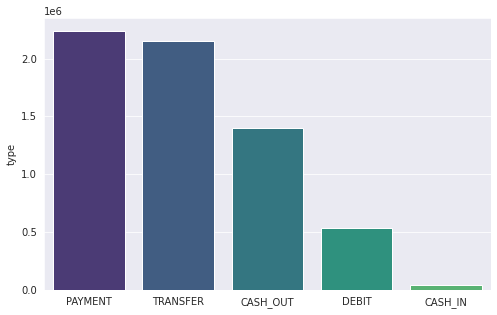

In [19]:
sns.set_style('darkgrid')
sns.set_palette("viridis")

f, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.barplot(x=df.type.drop_duplicates().values, y=df.type.value_counts())
plt.show()

#### Observation 2
As found above and from the visualization, we can see that the 'isFraud' is set only in two types of transactions - 'Cash_out' and 'Transfer'.

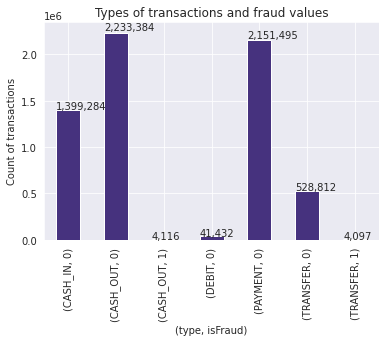

In [20]:
ax = df.groupby(['type', 'isFraud']).size().plot(kind='bar')
ax.set_title("Types of transactions and fraud values")
ax.set_xlabel("(type, isFraud)")
ax.set_ylabel("Count of transactions")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

#### Observation 3
'isFlaggedFraud' being set is not consistent with the range of values for 'amount', 'oldBalanceOrg', 'oldBalanceDest', as demonstrated by the box plots below.

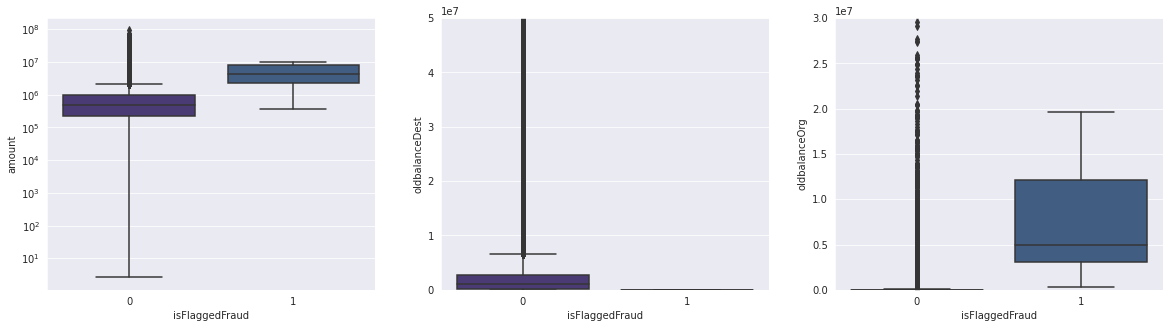

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
tmp = df.loc[(df.type == 'TRANSFER'), :]

a = sns.boxplot(x = 'isFlaggedFraud', y = 'amount', data = tmp, ax=axs[0])
axs[0].set_yscale('log')
b = sns.boxplot(x = 'isFlaggedFraud', y = 'oldbalanceDest', data = tmp, ax=axs[1])
axs[1].set(ylim=(0, 0.5e8))
c = sns.boxplot(x = 'isFlaggedFraud', y = 'oldbalanceOrg', data=tmp, ax=axs[2])
axs[2].set(ylim=(0, 3e7))

plt.show()


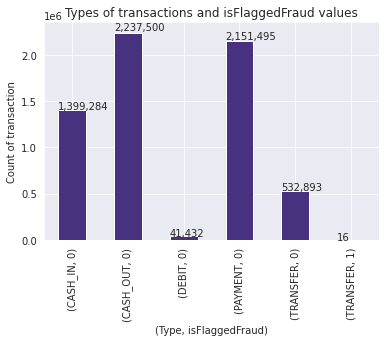

In [31]:
ax = df.groupby(['type', 'isFlaggedFraud']).size().plot(kind='bar')
ax.set_title("Types of transactions and isFlaggedFraud values")
ax.set_xlabel("(Type, isFlaggedFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

### Cleansing Data and Building Feature Set

From above charts and analysis, we know that only the types TRANSFER and CASH_OUT are in fradulent transactions. So picking only them be part of X.

In [32]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]
randomState = 5
np.random.seed(randomState)

Y = X['isFraud']
del X['isFraud']

X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int)

As shown above, there are a lot of 0s in 'oldBalanceOrg', 'newBalanceOrig', 'oldBalanceDest', 'newBalanceDest'. But the destination balances being 0 coul indicate fraud, I'll change them to -1. And change the 0's in origin balances to nan.

In [34]:
X.loc[(X.oldbalanceDest == 0) & (X.newbalanceDest == 0) & (X.amount != 0), \
      ['oldbalanceDest', 'newbalanceDest']] = - 1
X.loc[(X.oldbalanceOrg == 0) & (X.newbalanceOrig == 0) & (X.amount != 0), \
      ['oldbalanceOrg', 'newbalanceOrig']] = np.nan

Plotting a heat map to understand the correlation between features after cleaning.

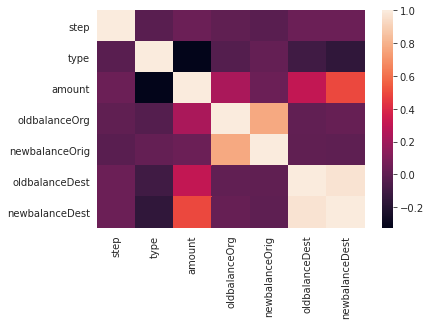

In [35]:
sns.heatmap(X.corr())

We can use Logistic Regression and XGBoost on this data to predict the Fraud transactions

In [36]:
X['errorBalanceOrig'] = X.newbalanceOrig + X.amount - X.oldbalanceOrg
X['errorBalanceDest'] = X.oldbalanceDest + X.amount - X.newbalanceDest

In [38]:
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, random_state = randomState)

In [39]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

##### XGBoost
The best result is obtained on the original dataset by using a ML algorithm based on ensembles of decision trees that intrinsically performs well on imbalanced data. Such algorithms not only allow for constructing a model that can cope with the missing values in our data, but they naturally allow for speedup via parallel-processing.Since the data is highly skewed, I use the area under the precision-recall curve (AUPRC) rather than the conventional area under the receiver operating characteristic (AUROC).

In [40]:
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, \
                n_jobs = 4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, \
                                              probabilities[:, 1])))

AUPRC = 0.9986361116985445


##### Logistic Regression
This needs the skewness in the data addressed before it is applied. 

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report

from statsmodels.tools import categorical

# 1. Keep only interested transaction type ('TRANSFER', 'CASH_OUT')
# 2. Drop some columns
# 3. Convert categorical variables to numeric variable
tmp = df.loc[(df['type'].isin(['TRANSFER', 'CASH_OUT'])),:]
tmp.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)
tmp = tmp.reset_index(drop=True)
a = np.array(tmp['type'])
b = categorical(a, drop=True)
tmp['type_num'] = b.argmax(1)

print(tmp.head(3))

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


       type     amount  oldbalanceOrg  ...  newbalanceDest  isFraud  type_num
0  TRANSFER     181.00          181.0  ...            0.00        1         1
1  CASH_OUT     181.00          181.0  ...            0.00        1         0
2  CASH_OUT  229133.94        15325.0  ...        51513.44        0         0

[3 rows x 8 columns]


In [56]:
# tmp.drop(['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'amount', 'type'], axis=0, inplace=True)

X = tmp.iloc[:, tmp.columns != 'isFraud']
y = tmp.iloc[:, tmp.columns == 'isFraud']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
lr = LogisticRegression(C = 0.001, penalty = 'l2')
lr.fit(X_train,y_train.values.ravel())
y_pred = lr.predict(X_test.values)

In [66]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

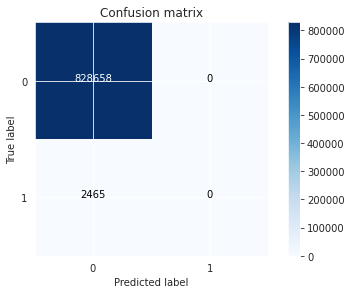

In [70]:

cnf_matrix = confusion_matrix(y_test,y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')


Apart from the above predictions, we can also use SVC. I haven't normalized due to time constraints but normalization can give better results in LR.